# Train-Holdout Sequential Synthesis Testing

This notebook performs the synthesis using our proposed synthesization approach for the training data only (excludes the holdout data).

In [1]:
import pandas as pd
import numpy as np
from numpy.random import default_rng
from sklearn.mixture import GaussianMixture
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing

from sklearn.tree import DecisionTreeClassifier

import itertools

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

from bayesian_bootstrap import bayesian_bootstrap

rng = np.random.RandomState(42)

In [2]:
# def cart_pmse_ratio(original_data, synthetic_data_sets):
    
#     ### get pmse measures for synthetic data set pairs
    
#     null_pmse_list = []
    
#     inds = np.arange(len(synthetic_data_sets))
    
#     combo_list = list(itertools.combinations(inds, 2))
    
#     for combo in combo_list:
    
#         s1 = synthetic_data_sets[combo[0]]
#         s2 = synthetic_data_sets[combo[1]]
    
#         N_orig = s1.shape[0]
#         N_synth = s2.shape[0]
    
#         c = N_synth/(N_synth+N_orig)
    
#         full_X = pd.concat([s1, s2], axis=0).reset_index(drop=True)
    
#         full_X = preprocessing.StandardScaler().fit_transform(full_X)

#         y = np.repeat([0, 1], repeats=[N_orig, N_synth])
    
#         cart = DecisionTreeClassifier(min_samples_split=20,
#                                       min_samples_leaf=int(np.round(20/3)),
#                                       ccp_alpha=0.0001,
#                                       max_depth=30)
    
#         cart.fit(X=full_X, y=y)
    
#         probs = cart.predict_proba(full_X)
    
#         pMSE = 1/(N_synth + N_orig) * np.sum((probs[:,1] - c)**2)
        
#         null_pmse_list.append(pMSE)
    
#     pmse_list = []
    
#     for s in synthetic_data_sets:
    
#         N_orig = original_data.shape[0]
#         N_synth = s.shape[0]
    
#         c = N_synth/(N_synth+N_orig)
    
#         full_X = pd.concat([original_data, s], axis=0).reset_index(drop=True)
    
#         full_X = preprocessing.StandardScaler().fit_transform(full_X)

#         y = np.repeat([0, 1], repeats=[N_orig, N_synth])
    
#         cart = DecisionTreeClassifier(min_samples_split=20,
#                                       min_samples_leaf=int(np.round(20/3)),
#                                       ccp_alpha=0.0001,
#                                       max_depth=30)
    
#         cart.fit(X=full_X, y=y)
    
#         probs = cart.predict_proba(full_X)
    
#         pMSE = 1/(N_synth + N_orig) * np.sum((probs[:,1] - c)**2)
        
#         pmse_list.append(pMSE)
    
#     return np.array(pmse_list)/(np.mean(null_pmse_list))

In [3]:
def pmse_ratio(original_data, synthetic_data):
    
    N_synth = synthetic_data.shape[0]
    N_orig = original_data.shape[0]
    
    # combine original and synthetic datasets
    full_X = pd.concat([original_data, synthetic_data], axis=0).reset_index(drop=True)
    
    full_X["age"] = full_X["age"].astype('category')
    
    age_dummies = pd.get_dummies(full_X['age'], drop_first=True)
    
    age_dummies.columns = [str(x) for x in age_dummies.columns]
    
    full_X = full_X.drop("age", axis=1)
    
    full_X = pd.concat([full_X, age_dummies], axis=1)
    
    # generate interactions and powers of variables
    poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
    
    full_X = poly.fit_transform(full_X)
    
    full_X = full_X[:,:-36]

    # scale the combined dataset
    full_X = preprocessing.StandardScaler().fit_transform(full_X)
    
    c = N_synth/(N_synth+N_orig)

    y = np.repeat([0, 1], repeats=[N_orig, N_synth])
    
    pMSE_model = LogisticRegression(penalty=None, max_iter=1000).fit(full_X, y)
    
    probs = pMSE_model.predict_proba(full_X)
    
    pMSE = 1/(N_synth+N_orig) * np.sum((probs[:,1] - c)**2)
    
    e_pMSE = 2*(full_X.shape[1])*(1-c)**2 * c/(N_synth+N_orig)
        
    return pMSE/e_pMSE

Import the data.

In [4]:
# import standardized lat/long location data
X = pd.read_csv("Data/cleaned_data.csv")

Number of locations from deceased individuals.

In [5]:
np.sum(X.state)

55

Split dataset into continuous and categorical variables.

In [6]:
X

,latitude,longitude,sex,age,state
0,0.944157,-1.010655,male,50s,0
1,0.889746,-0.694899,male,50s,0
2,0.917482,-0.682299,male,30s,0
3,0.916660,-0.682551,male,30s,0
4,0.886074,-0.668883,male,30s,0
...,...,...,...,...,...
6707,0.881500,-0.925307,male,40s,0
6708,-1.728784,1.470871,male,40s,0
6709,-1.548071,1.557316,male,40s,0
6710,-1.549392,1.555785,male,40s,0


In [7]:
cat_columns = X.select_dtypes(['object']).columns

In [8]:
X[cat_columns] = X[cat_columns].apply(lambda x: x.astype('category'))

In [9]:
categories = X[cat_columns].apply(lambda x: x.cat.categories)

In [10]:
X[cat_columns] = X[cat_columns].apply(lambda x: x.cat.codes)

In [11]:
categories

sex            Index(['female', 'male'], dtype='object')
age    Index(['0s', '10s', '20s', '30s', '40s', '50s'...
dtype: object

In [12]:
np.mean(X.sex)

0.4620083432657926

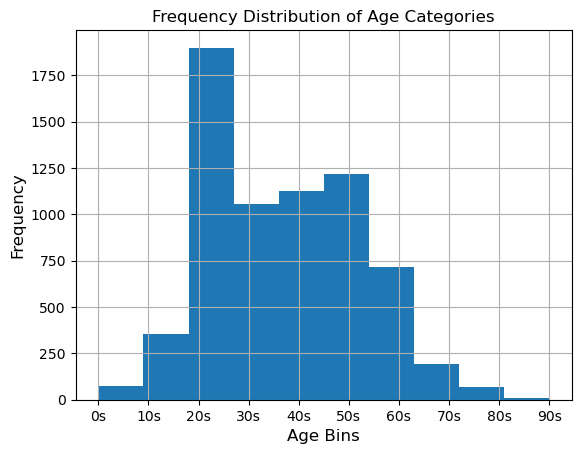

In [13]:
ax = X.age.plot.hist(grid=True, bins=10)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_xlabel('Age Bins', fontsize=12)
ax.set_xticks([0,1,2,3,4,5,6,7,8,9])
ax.set_xticklabels(labels=categories['age'])
plt.title("Frequency Distribution of Age Categories")
plt.show()

***

Create and save the training and holdout datasets.

In [14]:
shuffle_X = X.sample(frac=1.0, random_state=42).reset_index(drop=True)

half = int(np.ceil(shuffle_X.shape[0]/2))

train_data = shuffle_X.iloc[:half,:]
holdout_data = shuffle_X.iloc[half:,:]

In [15]:
train_data.to_csv("Data/synthetic_datasets/train_dataset.csv", index=False)
holdout_data.to_csv("Data/synthetic_datasets/holdout_dataset.csv", index=False)

***

Testing logistic and multinomial logistic regression synthesizers.

In [16]:
def polynomial_and_standardize(dataset, poly_degree=3, interaction_only=False):
    
    poly = PolynomialFeatures(degree=poly_degree, interaction_only=interaction_only, include_bias=False)
    
    X = poly.fit_transform(dataset)
    
    scaled_X = preprocessing.StandardScaler().fit_transform(X)
    
    return scaled_X

In [17]:
def multinomial_synthesizer(orig_data, synth_data_sets, target, penalty_param, poly_degree=3, interaction_only=False):
    
    mn_model = LogisticRegression(penalty='l1', C=penalty_param, solver='saga', max_iter=1000, multi_class='multinomial', random_state=rng)
    
    X = polynomial_and_standardize(dataset=orig_data, poly_degree=poly_degree, interaction_only=interaction_only)
    
    sXs = [polynomial_and_standardize(dataset=Y, poly_degree=poly_degree, interaction_only=interaction_only) for Y in synth_data_sets]
    
    vals = []
    
    mn_model.fit(X, target)
    
    rng_mn = default_rng()
    
    for Y in sXs:
        
        probs = mn_model.predict_proba(Y)
    
        v = [np.argmax(rng_mn.multinomial(n=1, pvals=p, size=1)==1) for p in probs]
    
        vals.append(pd.Series(v, name=target.name))
    
    return vals

In [18]:
def train_models_mn(#overall parameters
                    train_data,
                    number_synthetic_datasets,
                    # hyperparameters for GMM, end with underscore means Bayesian optimization will choose
                    number_gmm_initializations,
                    num_components_,
                    # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                    C_sex_,
                    C_age_,
                    C_state_):
    
    num_samples = train_data.shape[0]
    
    ########## Code for GMM ############
    
    # fit GMM model
    GMM = GaussianMixture(num_components_, n_init=number_gmm_initializations, init_params="k-means++", random_state=rng).fit(train_data.loc[:,["latitude", "longitude"]])
    
    # list for synthetic datasets
    sXs = []
    
    # generate and store number_synthetic_datasets synthetic datasets
    for i in range(number_synthetic_datasets):
        sX = GMM.sample(num_samples)[0]
        sX = pd.DataFrame(sX)
        sX.columns = ['latitude', 'longitude']
        sXs.append(sX)
        
    ####################################################################################################
        
    ########### Code for sex MN ##########
    
    synth_sex_vars = multinomial_synthesizer(orig_data=train_data.loc[:,["latitude", "longitude"]], 
                                             synth_data_sets=sXs, 
                                             target=train_data.sex, 
                                             penalty_param=C_sex_)
    
    sXs = [pd.concat([Y, synth_sex_vars[i]], axis=1) for i,Y in enumerate(sXs)]
        
    ####################################################################################################
        
    ########### Code for age MN ##########
    
    synth_age_vars = multinomial_synthesizer(orig_data=train_data.loc[:,["latitude", "longitude", "sex"]], 
                                             synth_data_sets=sXs, 
                                             target=train_data.age, 
                                             penalty_param=C_age_)
    
    sXs = [pd.concat([Y, synth_age_vars[i]], axis=1) for i,Y in enumerate(sXs)]
        
    ####################################################################################################
    
    ########### Code for state MN ##########
    
    synth_state_vars = multinomial_synthesizer(orig_data=train_data.loc[:,["latitude", "longitude", "sex", "age"]], 
                                               synth_data_sets=sXs, 
                                               target=train_data.state, 
                                               penalty_param=C_state_)
    
    sXs = [pd.concat([Y, synth_state_vars[i]], axis=1) for i,Y in enumerate(sXs)]
        
    ###### Calculate pMSE ratios ######
    pmse_ratios = [pmse_ratio(train_data, Y) for Y in sXs]
    # pmse_ratios = cart_pmse_ratio(train_data, sXs)
    
    return pmse_ratios, sXs, GMM

In [19]:
def optimize_models_mn(train_data,
                       number_synthetic_datasets,
                       number_gmm_initializations,
                       random_state):

    def evaluate_models(num_components_, C_sex_, C_age_, C_state_):

        pmse_ratios, _, _ = train_models_mn(train_data=train_data,
                                            number_synthetic_datasets=number_synthetic_datasets,
                                            number_gmm_initializations=number_gmm_initializations,
                                            num_components_=int(num_components_),
                                            C_sex_=C_sex_,
                                            C_age_=C_age_,
                                            C_state_=C_state_)
        
        return -1 * ((1 - np.mean(pmse_ratios))**2)

    optimizer = BayesianOptimization(
        f=evaluate_models,
        pbounds={
            "num_components_": (200, 800.99),
            "C_sex_": (0.001, 1),
            "C_age_": (0.001, 1),
            "C_state_": (0.001, 1)
        },
        random_state=random_state)
    
    utility = UtilityFunction(kind="ei", xi=1e-02)
    optimizer.set_gp_params(alpha=1e-3)
    optimizer.maximize(init_points=5, n_iter=25, acquisition_function=utility)
    print("Final Result: ", optimizer.max)
    return optimizer.max, optimizer

The default value for $\alpha = 1e-06$.

In [20]:
nsd = 20
ngi = 5
random_states = [np.random.RandomState(1234), np.random.RandomState(4321), np.random.RandomState(10620), np.random.RandomState(91695), np.random.RandomState(31296)]
# random_states = [np.random.RandomState(1234)]

In [21]:
optimization_results = [optimize_models_mn(train_data=train_data, number_synthetic_datasets=nsd, number_gmm_initializations=ngi, random_state=r) for r in random_states]

|   iter    |  target   |  C_age_   |  C_sex_   | C_state_  | num_co... |
-------------------------------------------------------------------------
| 1         | -0.06606  | 0.1923    | 0.6225    | 0.4383    | 672.0     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 2         | -0.106    | 0.7802    | 0.2733    | 0.2772    | 681.9     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 3         | -0.1094   | 0.9582    | 0.8761    | 0.3585    | 501.1     |
| 4         | -0.1363   | 0.6838    | 0.713     | 0.3709    | 537.3     |
| 5         | -0.05856  | 0.5036    | 0.01475   | 0.7731    | 730.5     |
| 6         | -0.02778  | 0.115     | 0.6913    | 0.2686    | 672.2     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 7         | -0.1112   | 0.9763    | 0.1497    | 0.462     | 495.7     |
| 8         | -0.116    | 0.3244    | 0.747     | 0.5125    | 672.4     |
| 9         | -0.0132   | 0.1331    | 0.6709    | 0.09145   | 672.5     |
| 10        | -0.03449  | 0.4215    | 0.7671    | 0.07766   | 672.9     |
| 11        | -0.06485  | 0.2861    | 0.4143    | 0.1214    | 672.6     |
| 12        | -0.1675   | 0.3857    | 0.608     | 0.6615    | 687.0     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 13        | -0.117    | 0.8675    | 0.808     | 0.5947    | 216.3     |
| 14        | -0.3935   | 0.4088    | 0.2138    | 0.007441  | 672.0     |
| 15        | -0.07556  | 0.4989    | 0.4481    | 0.1825    | 746.1     |
| 16        | -0.1303   | 0.4831    | 0.9274    | 0.4382    | 673.1     |
| 17        | -0.01879  | 0.2157    | 0.8659    | 0.03924   | 672.0     |
| 18        | -0.1342   | 0.4067    | 0.2443    | 0.7712    | 730.8     |
| 19        | -0.04222  | 0.1119    | 0.8626    | 0.1592    | 673.1     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 20        | -0.07336  | 0.9792    | 0.9668    | 0.8903    | 650.3     |
| 21        | -0.1106   | 0.5032    | 0.1146    | 0.8056    | 683.9     |
| 22        | -0.07821  | 0.1857    | 0.9014    | 0.9542    | 571.6     |
| 23        | -0.09774  | 0.2831    | 0.5485    | 0.4404    | 671.9     |
| 24        | -0.04478  | 0.1228    | 0.8938    | 0.3667    | 672.2     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 25        | -0.1348   | 0.76      | 0.2593    | 0.7162    | 729.8     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 26        | -0.07175  | 0.8436    | 0.7555    | 0.2184    | 350.2     |
| 27        | -1.419    | 0.129     | 0.7675    | 0.001     | 672.8     |
| 28        | -0.08266  | 0.6641    | 0.2081    | 0.1172    | 239.8     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 29        | -0.1122   | 0.9084    | 0.8579    | 0.3945    | 252.6     |
| 30        | -0.08799  | 0.3356    | 0.6278    | 0.3401    | 671.8     |
Final Result:  {'target': -0.013203329343496044, 'params': {'C_age_': 0.13307222020322645, 'C_sex_': 0.6708582978486902, 'C_state_': 0.09144742148020141, 'num_components_': 672.5069471463154}}
|   iter    |  target   |  C_age_   |  C_sex_   | C_state_  | num_co... |
-------------------------------------------------------------------------
| 1         | -0.0245   | 0.07173   | 0.8152    | 0.7681    | 372.1     |
| 2         | -0.06442  | 0.1939    | 0.9789    | 0.4068    | 655.4     |
| 3         | -0.02589  | 0.09006   | 0.3106    | 0.6193    | 476.4     |
| 4         | -0.07747  | 0.2191    | 0.6639    | 0.679     | 771.1     |
| 5         | -0.1042   | 0.282     | 0.6202    | 0.3839    | 440.6     |
| 6         | -0.05431  | 0.1199    | 0.1293    | 0.7899    | 372.6     |
| 7         | -0.1416   | 0.6152    | 0.8356    | 0.757     | 371.8

C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 12        | -0.1133   | 0.5818    | 0.4483    | 0.2489    | 319.9     |
| 13        | -0.09163  | 0.5698    | 0.4817    | 0.938     | 706.1     |
| 14        | -0.07521  | 0.2265    | 0.6123    | 0.0797    | 783.8     |
| 15        | -0.001674 | 0.439     | 0.5917    | 0.02444   | 498.6     |
| 16        | -0.08099  | 0.5142    | 0.7096    | 0.343     | 764.2     |
| 17        | -0.08342  | 0.5681    | 0.9739    | 0.5875    | 638.4     |
| 18        | -0.03295  | 0.2302    | 0.6514    | 0.07405   | 762.8     |
| 19        | -0.08523  | 0.4624    | 0.8952    | 0.4357    | 478.8     |
| 20        | -0.2621   | 0.02472   | 0.4846    | 0.7088    | 208.1     |
| 21        | -0.5094   | 0.02411   | 0.7833    | 0.06414   | 524.2     |
| 22        | -0.07054  | 0.407     | 0.3242    | 0.09901   | 285.1     |
| 23        | -0.03859  | 0.6887    | 0.03302   | 0.6651    | 514.9     |
| 24        | -0.1105   | 0.4009    | 0.1132    | 0.289     | 277.5     |
| 25        | -0.08739  | 0.3324    | 

C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 29        | -0.09517  | 0.9519    | 0.218     | 0.3618    | 454.4     |
| 30        | -0.07627  | 0.7419    | 0.2986    | 0.9169    | 676.4     |
Final Result:  {'target': -0.0016744010973787982, 'params': {'C_age_': 0.43901462089024973, 'C_sex_': 0.5917466622967009, 'C_state_': 0.02443781792885933, 'num_components_': 498.55909961264325}}
|   iter    |  target   |  C_age_   |  C_sex_   | C_state_  | num_co... |
-------------------------------------------------------------------------
| 1         | -0.0712   | 0.5169    | 0.3209    | 0.169     | 231.5     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 2         | -0.05953  | 0.9317    | 0.05982   | 0.4362    | 214.9     |
| 3         | -0.1223   | 0.492     | 0.7016    | 0.7721    | 441.7     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 4         | -0.07398  | 0.9199    | 0.5447    | 0.6874    | 348.1     |
| 5         | -0.06057  | 0.245     | 0.5641    | 0.2667    | 341.4     |
| 6         | -1.787    | 0.01302   | 0.2447    | 0.05875   | 326.0     |
| 7         | -0.1092   | 0.6783    | 0.7638    | 0.7984    | 223.0     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 8         | -0.08477  | 0.9609    | 0.7465    | 0.9868    | 215.7     |
| 9         | -21.22    | 0.001     | 0.001     | 0.001     | 200.8     |
| 10        | -0.01963  | 0.2929    | 0.7922    | 0.03231   | 428.9     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 11        | -1.815    | 1.0       | 0.001     | 0.001     | 245.9     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 12        | -0.01561  | 1.0       | 0.001     | 1.0       | 415.1     |
| 13        | -14.94    | 0.001     | 1.0       | 0.001     | 401.6     |
| 14        | -0.1371   | 0.5617    | 0.4581    | 0.8509    | 420.7     |
| 15        | -34.32    | 0.001     | 1.0       | 0.001     | 455.4     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 16        | -0.07262  | 0.8577    | 0.1029    | 0.7849    | 436.5     |
| 17        | -36.15    | 0.001     | 0.001     | 0.001     | 362.0     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 18        | -0.1531   | 1.0       | 1.0       | 1.0       | 311.8     |
| 19        | -0.034    | 0.3903    | 0.2522    | 0.07152   | 299.5     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 20        | -0.1142   | 0.476     | 0.5243    | 0.9958    | 286.6     |
| 21        | -0.04177  | 0.1429    | 0.2217    | 0.08986   | 273.0     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 22        | -0.2204   | 1.0       | 1.0       | 1.0       | 261.1     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 23        | -0.03137  | 0.9435    | 0.1191    | 0.06893   | 665.7     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 24        | -0.07233  | 0.8424    | 0.9346    | 0.9379    | 677.6     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 25        | -7.7      | 0.001     | 1.0       | 1.0       | 652.0     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 26        | -0.09115  | 0.8411    | 0.06467   | 0.3807    | 691.5     |
| 27        | -2.159    | 0.01209   | 0.7204    | 0.2116    | 704.3     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 28        | -0.1082   | 0.9873    | 0.9792    | 0.8654    | 723.8     |
| 29        | -0.0027   | 0.04945   | 0.5903    | 0.1632    | 735.6     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 30        | -0.1116   | 1.0       | 1.0       | 1.0       | 748.7     |
Final Result:  {'target': -0.0027000892606417904, 'params': {'C_age_': 0.04944790293948406, 'C_sex_': 0.590286828713736, 'C_state_': 0.16319975543930948, 'num_components_': 735.6260775254517}}
|   iter    |  target   |  C_age_   |  C_sex_   | C_state_  | num_co... |
-------------------------------------------------------------------------


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 1         | -0.09837  | 0.9739    | 0.9884    | 0.3971    | 547.1     |
| 2         | -0.0903   | 0.5583    | 0.3046    | 0.6306    | 280.9     |
| 3         | -0.09765  | 0.5341    | 0.7397    | 0.9104    | 416.8     |
| 4         | -0.005789 | 0.0451    | 0.8073    | 0.6553    | 560.9     |
| 5         | -0.1166   | 0.5853    | 0.1652    | 0.8145    | 541.5     |
| 6         | -0.09917  | 0.2965    | 0.7826    | 0.6079    | 565.9     |
| 7         | -0.05391  | 0.1253    | 0.3416    | 0.8001    | 220.5     |
| 8         | -0.01116  | 0.1661    | 0.03159   | 0.6936    | 341.8     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 9         | -0.09197  | 0.9583    | 0.8795    | 0.9924    | 756.7     |
| 10        | -0.1199   | 0.4001    | 0.7857    | 0.5295    | 402.6     |
| 11        | -0.08229  | 0.5369    | 0.05338   | 0.3515    | 592.2     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 12        | -0.1244   | 0.7815    | 0.7021    | 0.676     | 792.6     |
| 13        | -0.09104  | 0.3699    | 0.07209   | 0.6298    | 373.3     |
| 14        | -0.09127  | 0.4764    | 0.5064    | 0.4547    | 752.2     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 15        | -0.0719   | 0.8298    | 0.6411    | 0.3829    | 678.0     |
| 16        | -0.1      | 0.4114    | 0.258     | 0.6106    | 726.3     |
| 17        | -0.09031  | 0.5998    | 0.3643    | 0.219     | 279.2     |
| 18        | -0.08116  | 0.2453    | 0.4443    | 0.4345    | 559.6     |
| 19        | -0.07957  | 0.2503    | 0.6064    | 0.41      | 561.1     |
| 20        | -0.07253  | 0.1895    | 0.1163    | 0.6402    | 777.7     |
| 21        | -0.06882  | 0.258     | 0.5241    | 0.287     | 561.0     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 22        | -0.1131   | 0.849     | 0.4886    | 0.4297    | 693.0     |
| 23        | -0.03543  | 0.08924   | 0.5539    | 0.6823    | 561.0     |
| 24        | -0.01446  | 0.3496    | 0.006242  | 0.5401    | 605.6     |
| 25        | -0.09739  | 0.2146    | 0.9056    | 0.768     | 561.0     |
| 26        | -0.0746   | 0.3069    | 0.03941   | 0.7389    | 341.9     |
| 27        | -0.05496  | 0.1236    | 0.4921    | 0.8253    | 220.6     |
| 28        | -0.1034   | 0.3046    | 0.4022    | 0.8636    | 561.2     |
| 29        | -0.1358   | 0.6899    | 0.6846    | 0.6874    | 345.0     |
| 30        | -0.1361   | 0.5079    | 0.1486    | 0.3773    | 562.1     |
Final Result:  {'target': -0.005789013476860774, 'params': {'C_age_': 0.045104692886693616, 'C_sex_': 0.807290123028634, 'C_state_': 0.6553134468618701, 'num_components_': 560.9046936337465}}
|   iter    |  target   |  C_age_   |  C_sex_   | C_state_  | num_co... |
--------------------------------------------------------------------

C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 1         | -0.1219   | 0.8661    | 0.3078    | 0.8155    | 253.5     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 2         | -9.975e-0 | 0.8067    | 0.7034    | 0.01835   | 341.2     |
| 3         | -0.0563   | 0.2013    | 0.4947    | 0.2976    | 749.8     |
| 4         | -0.08964  | 0.6772    | 0.3474    | 0.11      | 743.9     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 5         | -0.0804   | 0.3711    | 0.1981    | 0.9662    | 360.8     |
| 6         | -0.09615  | 0.5471    | 0.5477    | 0.3054    | 367.6     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 7         | -0.1071   | 0.7857    | 0.9711    | 0.9627    | 335.8     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 8         | -0.08333  | 0.9218    | 0.5309    | 0.5892    | 506.0     |
| 9         | -0.05313  | 0.1522    | 0.9858    | 0.188     | 728.3     |
| 10        | -0.08725  | 0.2862    | 0.8369    | 0.6315    | 262.5     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 11        | -0.08163  | 0.2723    | 0.1264    | 0.1598    | 437.7     |
| 12        | -0.0124   | 0.3469    | 0.5873    | 0.03596   | 764.5     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 13        | -0.1154   | 0.9496    | 0.1697    | 0.547     | 487.0     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 14        | -0.1331   | 0.9151    | 0.0808    | 0.4787    | 572.4     |
| 15        | -0.09294  | 0.4717    | 0.2164    | 0.4892    | 703.0     |
| 16        | -0.03759  | 0.1026    | 0.6483    | 0.5066    | 407.3     |
| 17        | -0.09152  | 0.2266    | 0.1186    | 0.4509    | 502.3     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 18        | -0.1101   | 0.7941    | 0.9696    | 0.01051   | 341.5     |
| 19        | -0.1151   | 0.227     | 0.5123    | 0.3982    | 287.4     |
| 20        | -0.08517  | 0.2232    | 0.3761    | 0.7397    | 621.2     |
| 21        | -1.602    | 0.014     | 0.03489   | 0.7521    | 413.6     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 22        | -0.1345   | 0.8311    | 0.1977    | 0.5728    | 339.7     |
| 23        | -0.4988   | 0.1523    | 0.2789    | 0.007186  | 340.9     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 24        | -0.09044  | 1.0       | 0.9894    | 0.1305    | 340.9     |
| 25        | -0.06391  | 0.1353    | 0.9664    | 0.6443    | 764.4     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 26        | -0.09387  | 1.0       | 0.3269    | 0.2786    | 341.5     |
| 27        | -0.07388  | 0.2752    | 0.2351    | 0.1866    | 763.6     |
| 28        | -0.08167  | 0.2817    | 0.244     | 0.4141    | 765.2     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 29        | -0.05906  | 0.1708    | 0.1969    | 0.5769    | 406.3     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 30        | -0.11     | 0.9149    | 0.918     | 0.1562    | 407.0     |
Final Result:  {'target': -9.974741981172581e-05, 'params': {'C_age_': 0.8067420804502916, 'C_sex_': 0.7034321458083541, 'C_state_': 0.018349354612956555, 'num_components_': 341.2067323171185}}


In [22]:
run_targets = [np.minimum.accumulate(-i[1].space.target) for i in optimization_results]

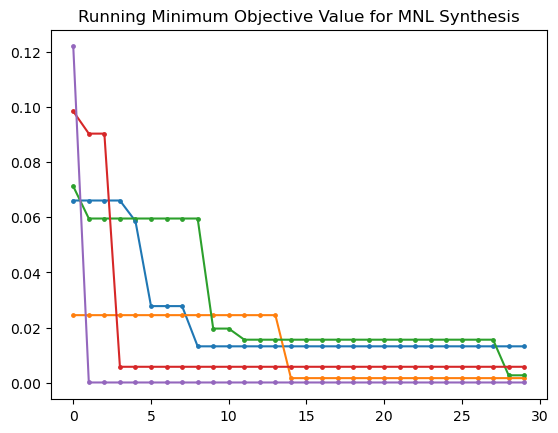

In [23]:
plt.plot(run_targets[0])
plt.scatter(np.arange(len(run_targets[0])), run_targets[0], s=6)
plt.plot(run_targets[1])
plt.scatter(np.arange(len(run_targets[1])), run_targets[1], s=6)
plt.plot(run_targets[2])
plt.scatter(np.arange(len(run_targets[2])), run_targets[2], s=6)
plt.plot(run_targets[3])
plt.scatter(np.arange(len(run_targets[3])), run_targets[3], s=6)
plt.plot(run_targets[4])
plt.scatter(np.arange(len(run_targets[4])), run_targets[4], s=6)
plt.title("Running Minimum Objective Value for MNL Synthesis")
plt.show()

Choose the params that gave the best objective value across all random seeds.

In [24]:
best_params = optimization_results[np.argmax([x[0]['target'] for x in optimization_results])][0]

In [25]:
best_params

{'target': -9.974741981172581e-05,
 'params': {'C_age_': 0.8067420804502916,
  'C_sex_': 0.7034321458083541,
  'C_state_': 0.018349354612956555,
  'num_components_': 341.2067323171185}}

Generate 20 synthetic data sets.

In [26]:
full_ratios, full_sXs, GMM = train_models_mn(train_data=train_data,
                                             number_synthetic_datasets=20,
                                             # hyperparameters for GMM
                                             number_gmm_initializations=ngi,
                                             num_components_=int(best_params['params']['num_components_']),
                                             # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                                             C_sex_=best_params['params']['C_sex_'],
                                             C_age_=best_params['params']['C_age_'],
                                             C_state_=best_params['params']['C_state_'])

C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [27]:
(1 - np.mean(full_ratios))**2

0.0015246003855374616

In [28]:
np.mean(full_ratios)

1.039046131505406

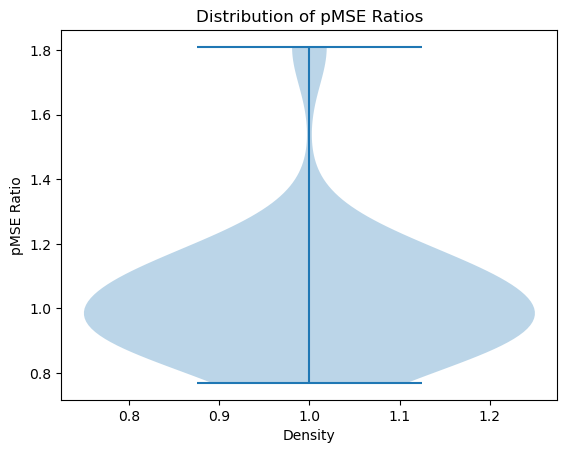

In [29]:
plt.violinplot(full_ratios)
plt.xlabel("Density")
plt.ylabel("pMSE Ratio")
plt.title("Distribution of pMSE Ratios")
plt.show()

# Save the synthetic datasets.

In [30]:
for i, sX in enumerate(full_sXs):
    sX.to_csv("Data/synthetic_datasets/logistic_logistic_synthetic_dataset_" + str(i) + ".csv", index=False)

***